# topic modeling pipeline

This notebook will walk you through:
1. data reterival from SQL database
2. Pre-processing data
3. Running topic modeling (different models)
4. post processing (including showing topics, topic-doc distribution, etc.)
5. Storing results into DB

# imports

In [1]:
from pre_processing import remove_html_tags, preprocess_data, prepare_corpus
from post_processing import topic_selection
from rpy2 import robjects #loading R inside Python
#importing functions to read pandas DF
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

import pandas as pd

import numpy as np

import os

#import R base library
base = importr('base')

mallet_path = 'mallet' #'mallet for mac-os

[nltk_data] Downloading package stopwords to /Users/das-
[nltk_data]     lab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/das-lab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/das-lab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/das-lab/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


loading stop words

In [8]:
#downloading github repo for down-sampling==> you only need this once!
# !git clone https://github.com/aminmarani/authorless-tms.git

Cloning into 'authorless-tms'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 36 (delta 3), reused 8 (delta 3), pack-reused 28
Receiving objects: 100% (36/36), 395.53 KiB | 4.82 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
stop_words = []

with open('freqPOS+Names.stop','r') as txtfile:
    for r in txtfile:
        stop_words.append(r.strip())
        if "'" in r:#add the term without "'"; e.g., haven't & havent
            stop_words.append(r.replace("'","").strip())

stop_words[10:15]

['duncan', 'fluffy', 'jack', 'jake', 'jim']

# Loading data from SQL database

First creating a connection

**In order to create a connection from anywhere in LU network you need to run the command below in terminal. Replace your username with amh418 in the command below.**

ssh -L 3306:127.0.0.1:3306 -N -f amh418@128.180.111.76   #it will ask for lehigh pass

on network (128.180.111.76)
outside the network (ssh.lehigh.edu)

**if you need to kill to SSH forwarding use the link below**

https://superuser.com/questions/87014/how-do-i-remove-an-ssh-forwarded-port


In [3]:
import mysql.connector

#connecting to DB
cnx = mysql.connector.connect(user='push', password='ElI)g!LDOBIwM)%*5o5{dbfz('
                              ,host='127.0.0.1',database='edml')

Retreiving all the posts

**We are exlcuding recoverwithmeda for now**

In [4]:
cursor = cnx.cursor() #making a cursor to execute a SQL command
# cursor.execute("select * from post") #execute a command
cursor.execute("select * from post where user_id != (select user_id from user where user_login='recoverwithmeda')") #execute a command
myresult = cursor.fetchall() #get all the results 
print('{0} posts were retreived'.format(len(myresult))) 

8341 posts were retreived


In [5]:
#loading user_id and user_name to convert id to user_name
cursor.execute("select * from user") #execute a command
users = cursor.fetchall() #get all the results 
users = {i[0]:i[1] for i in users}
myresult = [i[0:2] + tuple([users[i[2]]]) + i[3:] for i in myresult]

In [6]:
#concatenating the old dataset to the new one
myresult_ = [tuple(i[1:]) for i in pd.read_csv('./data/old_ed.csv',index_col=None).values]
myresult += myresult_
print('{0} posts were retreived'.format(len(myresult))) 

21338 posts were retreived


Language detection

keeping only English language posts/documents

In [7]:
from langdetect import detect
from tqdm import tqdm


# myresult = [s for s in myresult if len(remove_html_tags(s[3])) > 3 and detect(remove_html_tags(s[3]))=='en']
t = []
#removing tags and detecting language afterward
for s in tqdm(myresult):
    try:#in some case language detection may fail (emojies only, one word docs, etc.) ==> We don't keep those
        if detect(remove_html_tags(s[3]))=='en':
            t.append(s)
    except:
        pass #do nothing

myresult = t[:]
print('after removing non-english posts,the size of the documents are: {0}'.format(len(myresult)))

100%|████████████████████████████████████| 21338/21338 [03:00<00:00, 118.22it/s]

after removing non-english posts,the size of the documents are: 17301


# preprocessing the data

First, removing html tags

prepare the corupus

In [9]:
#removing tags from texts
proc_texts = [remove_html_tags(i[3]) for i in myresult]
#pre_processing and tokenizing docs
pre_processed_docs,orig_docs = preprocess_data(proc_texts,extra_stopwords=stop_words)
#attaching (id,original_text,pre_processed_text,date,url) together
id_text = [(myresult[orig_docs[i][1]][0],orig_docs[i][0],pre_processed_docs[i],
            myresult[orig_docs[i][1]][4],myresult[orig_docs[i][1]][5],
            myresult[orig_docs[i][1]][2]) for i in range(len(orig_docs))]

# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs) ==> we don't need prepare corpus as we are passing this to LDA and STM R and there they will do tokenization 

#creat a pandas DF with one column as text, one column as original text, one column as SQL post-id, etc.
text_df = pd.DataFrame(zip([i[0] for i in id_text],[' '.join(i[2]) for i in id_text],
                           [i[1] for i in id_text],[i[3] for i in id_text],[i[4] for i in id_text],
                          [i[5] for i in id_text]),
                       columns=['id','text','original_text','date','url','blog'])

In [10]:
#removing duplicates only if necessary
print(len(text_df))
text_df = text_df.drop_duplicates(subset=['text'])
print(len(text_df))

14335
13620


Processing documens for Topicalizer

In [7]:
# text_df[['date','original_text','url']].rename(columns={'original_text':'entry','url':'Link'}).to_csv('./data/processed_ed.csv')

# Author down-sampling

down-sampling terms that are more specific to an author

In [15]:
vocab = set()

for tx in list(text_df.text):
    tokens = tx.split()
    [vocab.add(t) for t in tokens]

with open('./data/temp_vocab_corpus.txt','w') as tfile:
    tfile.writelines([i+'\n' for i in list(vocab)])

print('size of dictionary is {0}'.format(len(vocab)))

size of dictionary is 33110


In [45]:
#storing corpus for down-sampling (we send the pre-processed docs)
text_df[['blog','text']].to_csv('./data/temp_documents_corpus.txt',index=True,sep='\t',
                                header=False,encoding="UTF-8")

In [71]:
#running down-sampling ==> if the original file in repo pops error you need to make changes in the downsample_corpus.py as stated below
#line 68: term_means = np.mean(author_term_freqs, axis=0).ravel() 
#line 71: term_vars = np.var(author_term_freqs, axis=0, ddof=1).ravel()
#line 83: author_term_freqs = author_term_freqs.toarray()#added 2023,Nov
#line 88: author_freqs = author_term_freqs[:, term_id].ravel()#.getA1() #added 2023,Nov
# !python3 ./authorless-tms/downsample_corpus.py --input ./data/temp_documents_corpus.txt --output ./data/temp_documents_corpus_new005.txt --vocab ./data/temp_vocab_corpus.txt --threshold 0.05

Building doc-term matrix
Building author-term matrix
Building stop weights
Downsampling file


In [96]:
#updating text_df
new_df = pd.read_csv('./data/temp_documents_corpus_new005.txt',sep='\t',header=None,
                     names=['blog','text'])

#replacing down-sampled data with original data
for id,row in tqdm(new_df.iterrows()):
    text_df.at[id,'text'] = row['text']

#removing the ones that were deleted during down-sampling
text_df = text_df[text_df.index.isin(new_df.index)]

print('Number of documents after down-sampling: {0}'.format(len(text_df)))

8629it [00:00, 11621.66it/s]

Number of documents after down-sampling: 8629


# Running topic modeling (with or without evaluation)

In [8]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')

# utils.install_packages('stm',repos="https://cloud.r-project.org")

In [97]:
is_eval = True #not evaluating the model
lon,upn = 5,26 #lowwer and upper topic number for evaluation
#need to provide number of topics and other specification
model_spec = {'name':'LDA','K':21,'epochs':2000,'burnin_iteration':20,'after_iteration_burnin':50,
             'save_flag':True,'save_path':'LDA_test'}
# model_spec = {'name':'STM','K':90,'epochs':500,'prevalence':'','content':'','pre_trained_model': 'LDA',\
#                 'burnin_iteration':20,'LDA_epochs':50,'save_flag':True}

if model_spec['name'] == 'LDA':
    if is_eval:
        #loading LDA mallet evaluation score
        from lda_mallet import lda_score
        from gensim.corpora import Dictionary
        import pickle
        from pre_processing import prepare_corpus
        #creating data vocab
        dict = Dictionary([i.split() for i in list(text_df.text)])
        #saving it to pass it to score object
        with open ('./data/ED_vocab.obj','wb') as vfile:
            pickle.dump(dict,vfile)
        wiki_vocab_dict_path = './data/wiki_sampled5p_vocab.obj'
        with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
            wiki_vocab_dict = pickle.load(vfile)


        npmis = []
        for n_topics in range(lon,upn,1):
            #removing terms that are not in the Wiki Vocab
            #pre_processing and tokenizing docs
            # pre_processed_docs,_ = preprocess_data(list(text_df.text),extra_stopwords=\
            #                                                set(dict.values()).difference(set(wiki_vocab_dict.values()))\
            #                                        .union(['denying']))
            pre_processed_docs,_ = preprocess_data(list(text_df.text))
            #preparing corpus
            vocab_dict,doc_term_mat = prepare_corpus(pre_processed_docs)
            #temp save of vocab file
            with open ('./data/ED_vocab.tmp','wb') as vfile:
                pickle.dump(vocab_dict,vfile)
            
            scorer = lda_score(num_topics=n_topics,alpha=10,optimize_interval=10,iterations=2000,wiki_path='./data/wiki_sampled_5p.txt',
                      db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                      wiki_vocab_dict_path=wiki_vocab_dict_path,npmi_skip_threshold=0.30)
            
            scorer.fit(doc_term_mat)#fitting an LDA Mallet
            npmis.append([n_topics,scorer.score()])
    else: 
        #removing previously created mallet_file
        try:
            os.remove('MalletInstance_ {0}'.format(model_spec['save_path'])) 
            os.remove('MalletState_ {0} .gz'.format(model_spec['save_path']))
            os.remove('MalletSpec_ {0}'.format(model_spec['save_path']))
        except:#in case we don't have any files
            pass
        robjects.r.source('LDA_R.R')
        copy_text_df = text_df.copy()
        ans = robjects.r.findTopics(docs = copy_text_df,n_topics = model_spec['K'],epochs = model_spec['epochs'],
                                    burnin_iteration = model_spec['burnin_iteration'],
                                    after_iteration_burnin =  model_spec['after_iteration_burnin'],
                                    save_flag=model_spec['save_flag'],save_path = model_spec['save_path'])
        top_terms = np.asarray(ans[1])
        topic_doc_dist = np.asarray(ans[0][0]).T
        term_probab = ans[0][1]
        topic_vocab = ans[0][2]
        
        
elif model_spec['name'] == 'STM':
    if is_eval:
        pass
    else: 
        robjects.r.source('stm.R')
        ans = robjects.r.run_stm(docs = text_df,topic_n=model_spec['K'],max_itr=model_spec['epochs'],
                                 prevalence=model_spec['prevalence'],content=model_spec['content'],
                                 model_type = model_spec['pre_trained_model'],
                                 nits = model_spec['LDA_epochs'],burnin = model_spec['burnin_iteration'],
                                 save_flag = True)
        top_terms = np.asarray(ans[1]).reshape(model_spec['K'],50,order='F')
        topic_doc_dist = 0.00

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.44351
<20> LL/token: -8.09665
<30> LL/token: -7.99856
<40> LL/token: -7.96087

0	2	time life love year hope friends things happy week today back people day home big live share face start grateful 
1	2	body eating life feel people weight recovery health disorder things healthy love ed real important change mental support care matter 
2	2	cup chocolate vegan bowl add protein butter minutes free water milk tbsp cream mix cheese sweet sugar top set oil 
3	2	feel time back things question answer felt hard talk bit good lot feeling brain work therapy thought thing feels week 
4	2	day food eat good today time days eating morning night foods full home meals enjoy feeling meal ate rest calories 

<50> LL/token: -7.94066
<60> LL/token: -7.92512
<70> LL/token: -7.91399
<80> LL/token: -7.91258
<90> LL/token: -7.90709

0	2	life love time year hope week happy back day friends things

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.50038
<20> LL/token: -8.14835
<30> LL/token: -8.05416
<40> LL/token: -8.00983

0	1.66667	eating food eat people recovery day care feel health good give disorder gonna diet shit mental fucking disorders lot calories 
1	1.66667	life body love feel things people world happy time change live real years healthy living mind feeling day beautiful health 
2	1.66667	time back day today home week year school friends days family good bit long work run stay hours tomorrow bed 
3	1.66667	cup chocolate vegan add protein butter free bowl minutes milk tbsp cake mix set sugar bread #healthy almond oats top 
4	1.66667	day good today meal love eat meals lunch full dinner morning happy weekend food time week super water night breakfast 
5	1.66667	feel weight things hard time talk felt question back answer bad body eating thing brain lot good therapy thoughts feeling 

<50> LL/token: -7.98

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.56325
<20> LL/token: -8.19524
<30> LL/token: -8.08551
<40> LL/token: -8.03766

0	1.42857	people feel time good shit fucking care literally gonna put skin give pretty lol life hate bc person fuck hair 
1	1.42857	day love today good week meal full time lunch post super dinner fun breakfast enjoy guys based easy favorite happy 
2	1.42857	day time today home back year friends days family night hope school morning week happy good bed run tomorrow hours 
3	1.42857	life love things body feel people change world years live health support start real care happy mental hope disorders beautiful 
4	1.42857	eating food eat body recovery feel weight healthy day disorder ed good foods bad health days diet lot time calories 
5	1.42857	feel time things felt question hard talk answer back work thought therapy bit week feeling lot feels end brain good 
6	1.42857	cup chocolate vegan bowl a

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.63495
<20> LL/token: -8.22651
<30> LL/token: -8.10936
<40> LL/token: -8.06314

0	1.25	eating recovery people disorder care ed mental health support disorders lot binge hard struggling life proud sick years control person 
1	1.25	day time good today feel gonna days literally fucking bed pretty shit sleep work lol put feeling nice night hours 
2	1.25	cup chocolate vegan add protein butter bowl minutes free milk tbsp cake mix water sugar sweet oil bread #healthy almond 
3	1.25	body food eat weight feel life healthy eating things day foods health good diet live calories love deserve energy change 
4	1.25	feel things talk time life felt feeling therapy thought people thing week hard told part mind thoughts feels work start 
5	1.25	day today good meal morning week eat lunch breakfast dinner weekend full meals night time happy sunday yesterday cheese veggies 
6	1.25	love life

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.73805
<20> LL/token: -8.33134
<30> LL/token: -8.18456
<40> LL/token: -8.11465

0	1.11111	feel things time feeling lot brain work hard life good control thing important energy feels bad food find stop fear 
1	1.11111	food eat day good meal meals foods lunch dinner full eating breakfast today favorite vegan super post based ate eggs 
2	1.11111	bit question time answer week back talk things felt therapy therapist talking stuff parents thought end run started asked ago 
3	1.11111	cup chocolate bowl add butter vegan protein minutes milk tbsp free cream mix water sugar oil bread #healthy almond oats 
4	1.11111	eating weight recovery disorder people ed eat food feel shit fucking calories binge bad gonna gain lose sick stop back 
5	1.11111	love hope share start life time free give live week happy show amazing bio link story big video full watch 
6	1.11111	people years time ba

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.70946
<20> LL/token: -8.28407
<30> LL/token: -8.14923
<40> LL/token: -8.09455

0	1	cup chocolate protein butter free milk tbsp add vegan cake mix sugar bowl almond set oats banana top peanut coconut 
1	1	time back school year years friends stay question story family answer place baby home long job ago call read children 
2	1	feel things time talk felt back hard week therapy bit lot thought feels feeling therapist brain thing talking good told 
3	1	life love things time hope year care world grateful support free people month work live taking share bio link reminder 
4	1	body weight life health healthy feel diet things years live eating bodies thoughts matter important worth mind change control gain 
5	1	vegan cheese meal water bowl favorite sweet rice cream cook oil #fitness avocado veggies love roasted plant potato #glutenfree sauce 
6	1	love people life feel real go

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.78064
<20> LL/token: -8.34975
<30> LL/token: -8.20386
<40> LL/token: -8.1414

0	0.90909	food eat eating body feel healthy good foods day weight diet health lot calories meals binge exercise ate bad hungry 
1	0.90909	day today morning good week breakfast lunch night cheese yesterday dinner sunday home weekend pm meal pasta happy toast sweet 
2	0.90909	eating people disorder life care health support world mental disorders work recovery person learn part month proud journey struggling loved 
3	0.90909	love day life time friends things happy today good feeling feel grateful year live hope people pretty days energy spend 
4	0.90909	hope love post week free life time guys change heart find things give thing today read hair share set world 
5	0.90909	vegan water based white cook veggies black favorite super roasted plant red rice meal sauce full easy love cooking green 
6	0

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.77596
<20> LL/token: -8.3254
<30> LL/token: -8.19433
<40> LL/token: -8.1346

0	0.83333	cheese water cream bowl rice meal frozen cook avocado veggies oil roasted pasta dinner add high sauce #foodblogger toast red 
1	0.83333	question answer talk bit therapy things week felt time back feel talking lot parents thought end asked school told stuff 
2	0.83333	real feel life love people things good happy social post live person week start day change perfect media wear find 
3	0.83333	life things time feel work hard thoughts feels feeling mind world past thought start back felt living years lot place 
4	0.83333	time home back year day long house big walk fuck today work decided literally crazy finally put hair family wait 
5	0.83333	food love free good time day link coffee pm full vegan post share fun favorite bio friends ice dinner family 
6	0.83333	love life people body hop

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.80661
<20> LL/token: -8.36305
<30> LL/token: -8.21801
<40> LL/token: -8.1475

0	0.76923	cup chocolate add butter protein milk minutes tbsp bowl free water mix vegan cake oil #healthy almond oats banana salt 
1	0.76923	eating people disorder recovery health mental disorders support care proud struggling part fear healing life understand culture hard person call 
2	0.76923	body life feel things love happy change real people feeling beautiful mind live bodies thoughts worth world social thing human 
3	0.76923	back home time run bit school stay today running house week tomorrow minutes baby hours yesterday weeks room big half 
4	0.76923	life year share time years work love world friends past living bio start ago grateful link care month taking family 
5	0.76923	love hope post guys people week live skin give wear photo show video instagram online comments read photos orde

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.8767
<20> LL/token: -8.41318
<30> LL/token: -8.25587
<40> LL/token: -8.18499

0	0.71429	body weight feel healthy bodies day health gain change bad food size exercise image fat skin good lifestyle happy life 
1	0.71429	love post time share guys find story photo week book follow friend big instagram read start friends fun wait women 
2	0.71429	cup chocolate butter protein tbsp milk vegan add mix bowl free almond oats banana peanut coconut sugar set powder bread 
3	0.71429	food eat eating foods good meal meals full calories ate enjoy cake ice healthy girl cream thing based vegan post 
4	0.71429	time things back week felt bit school feel work years past year talk end times thought hard talking feels head 
5	0.71429	time gonna shit feel literally good back lol fucking friends bc pretty wanna life care hate nice hair house idk 
6	0.71429	hope year free day home live month 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.86269
<20> LL/token: -8.41154
<30> LL/token: -8.26419
<40> LL/token: -8.18965

0	0.66667	life love people things real world live social feel beautiful living happy change perfect big media post wear photos show 
1	0.66667	things felt talk feel therapy brain bit answer time question week back stuff thought started talking therapist told good asked 
2	0.66667	fucking good shit gonna literally give people bc question fuck answer day friends lol wanna friend pretty house put tag 
3	0.66667	eating recovery disorder ed mental health disorders binge support people struggling proud treatment stop blog recover hard disordered call pro 
4	0.66667	time back long run find home face book place hair reading finally year full work training mind read half found 
5	0.66667	food eat eating good meals meal full day foods easy based hungry enjoy ate hunger plant black snacks time snack 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 16 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.8746
<20> LL/token: -8.41563
<30> LL/token: -8.27846
<40> LL/token: -8.20565

0	0.625	eating people recovery disorder support mental disorders health care life hope proud struggling world community treatment call part free journey 
1	0.625	people feel things world person real good lot read kind skin social important human online wear time find women beautiful 
2	0.625	body weight feel life change control bodies thoughts years things mind gain healthy deserve power matter worth image lose love 
3	0.625	day today morning good breakfast meals lunch dinner food night cream yesterday ice eat meal back snack afternoon sunday pizza 
4	0.625	day home time year today friends night coffee bed family weekend christmas holiday fun pm hope friend sleep tomorrow give 
5	0.625	back time place minutes times put work bit hold stop mind sit left yeah long eventually half fact sitting 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 17 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.89745
<20> LL/token: -8.41935
<30> LL/token: -8.27306
<40> LL/token: -8.20691

0	0.58824	today day good week morning happy weekend breakfast night home lunch sunday yesterday days friends time busy work afternoon rest 
1	0.58824	eating recovery people disorder ed mental care disorders health fucking support fuck shit struggling proud person treatment blog trauma recover 
2	0.58824	day time home today days bed sleep run running night morning hours coffee feeling tomorrow drink stay walk back bad 
3	0.58824	friend friends people work money follow share tag book open time hospital story love mom stay call big give called 
4	0.58824	love year remember people today grateful big beautiful comment family pretty live life deserve photos loved link cute forget friends 
5	0.58824	feel time back brain bit good long things face week start felt stuff thing end hard point started

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.91364
<20> LL/token: -8.44708
<30> LL/token: -8.30134
<40> LL/token: -8.23837

0	0.55556	food foods time good based vegan eat enjoy day diet coffee plant fun drink free code lot culture work choose 
1	0.55556	eating recovery disorder people ed fucking shit disorders care mental health support fuck gonna sick struggling hate treatment proud blog 
2	0.55556	day days today feel good hope time feeling work things back give long morning care bad hours rest week taking 
3	0.55556	cup butter protein milk tbsp bowl almond oats banana peanut chocolate coconut powder add vanilla seeds recipe frozen #healthy mix 
4	0.55556	home time back school question run answer family house running weeks dad baby long bc left nice bit stay friends 
5	0.55556	people pretty thing lot find point lol watch video comment literally live white question talk answer bit fact means honestly 
6	0.5555

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 19 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.91683
<20> LL/token: -8.44538
<30> LL/token: -8.29497
<40> LL/token: -8.22631

0	0.52632	food eat eating day foods meals good ate diet meal healthy lot feel full hunger days enjoy body health lunch 
1	0.52632	feel hard brain feeling felt time feels talking anxiety things bad anxious back place lot feelings days tired work hungry 
2	0.52632	life people time things world real years social change find media lives true live love fear person moment remember spend 
3	0.52632	talk things therapy week question bit feel answer good felt thing therapist thought part end asked wanted stuff session child 
4	0.52632	cheese cook meal water veggies bowl roasted pasta potato sweet rice vegan red sauce oil dinner lunch avocado garlic minutes 
5	0.52632	body feel things matter mind calories good skin thing image change stop feeling energy worth bad size important power negative 
6	0.

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.94569
<20> LL/token: -8.47944
<30> LL/token: -8.32445
<40> LL/token: -8.25101

0	0.5	body healthy health feel bodies exercise rest change workout years past skin strong power energy important lifestyle size mind choose 
1	0.5	eating food eat weight recovery ed body foods disorder healthy calories binge feel gain meals lose hunger loss bad hungry 
2	0.5	shit fucking feel sleep gonna back time bed fuck bc lol wanna good bad hard nice house night stomach ass 
3	0.5	love run family favorite post summer tag follow guys free home friends sister birthday fun found extra good enjoy box 
4	0.5	cheese cook veggies roasted pasta oil meal sauce minutes water cream red sweet potato add vegan dinner garlic rice avocado 
5	0.5	back time school life year face years world home side place months people money smile lot stay end live friends 
6	0.5	day today home week time days happy m

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 21 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.95391
<20> LL/token: -8.49232
<30> LL/token: -8.34231
<40> LL/token: -8.2625

0	0.47619	time school question answer back year family home face uk parents stay house baby person long girls friend decided weeks 
1	0.47619	eating recovery disorder food eat ed day full hungry meals hunger ate meal lunch disordered pro dinner eaten snack breakfast 
2	0.47619	eating health care support mental hope disorders friend people give share free struggling loved recovery call follow text proud part 
3	0.47619	body love feel people life change remember bodies beautiful day image worth things deserve matter person power accept strong mirror 
4	0.47619	weight body healthy health feel gain lose time number loss mental important lost fat lot matter relationship normal physical low 
5	0.47619	cream cheese water vegan favorite based high cold plate lunch hot veggie summer beans easy supe

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 22 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.95511
<20> LL/token: -8.49795
<30> LL/token: -8.35138
<40> LL/token: -8.2808

0	0.45455	week hope weekend day happy today time good back full home guys sunday love workout video fun friends busy morning 
1	0.45455	cheese water cook rice veggies roasted pasta bowl oil cream sauce avocado lunch garlic minutes veggie #fitness salt vegan add 
2	0.45455	feel things time back anxiety remember place hard feeling past bad brain pain sad times feelings emotions control move present 
3	0.45455	cup butter chocolate add tbsp mix bowl oats milk banana set peanut coconut almond minutes cake powder frozen sugar completely 
4	0.45455	body weight healthy calories diet health gain fat lose bodies culture number loss feel food skinny fit matter eat bad 
5	0.45455	year love link coffee friends holiday time bio post share watch fun christmas amazing free drink full stories day shop 
6	0

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.98275
<20> LL/token: -8.50812
<30> LL/token: -8.35962
<40> LL/token: -8.28335

0	0.43478	things brain hard feel lot feels anxiety times past work end treatment find feelings head sense thoughts safe child stuff 
1	0.43478	things people years talk felt world feel lot time important part voice remember words thought story care hear wanted proud 
2	0.43478	therapy question bit answer time talk felt week feel started thing back told thought asked parents session good talking things 
3	0.43478	time life days social friends past hair find good lot years fun long full family content media people year watch 
4	0.43478	cup chocolate tbsp cake butter add free sugar set vegan mix completely minutes baking place cookie bake cool ingredients top 
5	0.43478	eating disorder recovery health mental support disorders care hope free part community struggling share life information lov

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 24 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -8.95962
<20> LL/token: -8.49714
<30> LL/token: -8.35423
<40> LL/token: -8.28148

0	0.41667	life body things love feel change years living live social mind thoughts real negative media positive power happy choose image 
1	0.41667	people ed answer recovery time feel question bc blog wanna shit good find hard gonna idk person give post drink 
2	0.41667	love share free link bio story post guys excited friends give tag stories follow order step super wait amazing month 
3	0.41667	food eat eating foods healthy body meals feel good health meal day lot hungry full ate diet hunger energy snacks 
4	0.41667	cheese bowl water cook veggies rice pasta roasted vegan add minutes sauce oil avocado cream sweet potato #fitness meal #healthy 
5	0.41667	good easy super favorite fun yesterday based salad workout plant side love half hit vegan taste simple plate post store 
6	0.41667	love l

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 25 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 606
total tokens: 444447
<10> LL/token: -9.01177
<20> LL/token: -8.51848
<30> LL/token: -8.37169
<40> LL/token: -8.29912

0	0.4	today day morning good home breakfast happy lunch week night yesterday cream sunday afternoon taking rest pm class lots busy 
1	0.4	food good day time pretty thing today days great dinner buy eat extra lot family honestly big full night birthday 
2	0.4	love life happy things day week people social remember real live photos hope friends media grateful post happiness time enjoy 
3	0.4	#healthy cheese #fitness bread sweet vegan #glutenfree #foodblogger #healthyinspo potato #vegan #healthyfood egg #wellness recipe favorite #healthylife #thenewhealth week toast 
4	0.4	home run time day back today running sleep bed house night hours stay big watch bit baby pretty week half 
5	0.4	life people things world feel hard big living work love journey healing learn find purpose finally share words

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


<Axes: xlabel='n_topics', ylabel='npmi_average'>

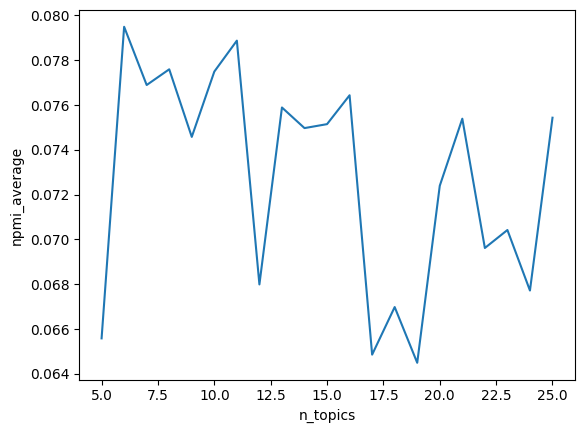

In [98]:
#new and old dataset with downsampling
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

In [16]:
#new and old dataset
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

<Axes: xlabel='n_topics', ylabel='npmi_average'>

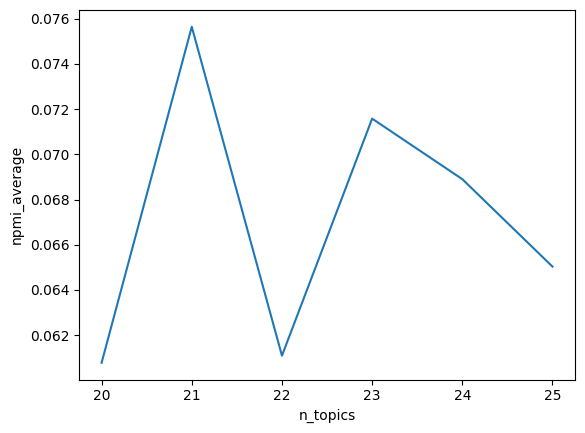

In [18]:
#new dataset
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

# Post-processing

topic distribution and topic selection

for topic selection I used elbow method (selecting top topics till we get to the highest gap)

In [99]:
#topic selection
topics4docs,topics4docs_bin = topic_selection(topic_doc_dist)

#topic distribution addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_dist'.format(i)] = topic_doc_dist[:,i]
#topic selection addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_select'.format(i)] = topics4docs_bin[:,i]

#saving data to csv
text_df.to_csv('document_topic_info.csv')

NameError: name 'topic_doc_dist' is not defined

In [21]:
#storing top terms
topic_df = pd.DataFrame(data=top_terms,columns=['top_terms'])
topic_df.to_csv('topic_terms.csv')

Running Coherence

In [22]:
from lda_mallet import lda_score
import pickle

# import importlib
# importlib.reload(scorer.score_per_topic(None))

#initiate scorer
scorer = lda_score(wiki_path='./data/wiki_sampled_5p.txt',db_path='./data/wiki_full/',npmi_skip_threshold=0.17)

'''
loading wikipedia vocab to 
    1. remove the top terms that are not in the wikipedia
    2. use for gensim.coherence vocab argument in case any pairs are not in the DB
'''
with open('./data/wiki_sampled5p_vocab.obj','rb') as f:
    scorer.wiki_vocab_dict = pickle.load(f)
    
#add all_top_terms (except the ones that are not in the wiki_pedia vocab)
scorer.all_top_terms = [[t for t in top_terms[i].split() if t in scorer.wiki_vocab_dict.token2id.keys()] for i in range(len(top_terms))]
#the output is a dictionary: the key is 0-n_topics and associated with npmi score for top-k topics 
#in which k=5,10,15,20
topic_scores = scorer.score_per_topic(None)
#getting avergae of multiple k for each topic
topic_score_avg = [np.mean([vi for ki,vi in v.items()]) for k,v in topic_scores.items()]

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.17


# soring top terms and top documents

In [23]:
show_top_doc = 10
show_top_terms = 10
file_name = 'top_documents_lda21_new_old_data_new_stopwords_only_english.txt'

#writing the results in a text file
with open(file_name,'w') as tfile:
    for i in range(len(top_terms)):
        #writing top terms
        tfile.write('Topic '+ str(i) + ' : '+'\n'+'top terms: '+', '.join(top_terms[i].split()[:show_top_terms])+'\n')
        #selecting top documents
        top_docs = text_df.sort_values('Topic{0}_dist'.format(i),ascending=False).iloc[0:show_top_doc,:]
        for _,row in top_docs.iterrows():
            tfile.write('Doc ID: {0}, distribution: {1} ; {2} \n'.format(row.id,row['Topic{0}_dist'.format(i)],row['original_text']))
            tfile.write(''.join(['-']*60)+'\n')
        

# Storing to DB

The process is described in the code cell below

**Used the link below to insert and load blob**

https://pynative.com/python-mysql-blob-insert-retrieve-file-image-as-a-blob-in-mysql/

In [15]:
#1. save model id (for LDA save as zip and then save)
'''
2. for each topic
    3. save topic
    4. retreive the saved topic_id and save r_topic_model
    5. for each doc save r_topic_post
'''
###table format
#model: model_id, data, model_type, last_used?
# topic: topic_id, coherence, term1-50, probab1-50
#r_topic_model: topic_id, model_id 
#r_topic_post: topic_id, post_id, proportion

##check the columns of a table
# cursor.execute("show columns from r_topic_post") #execute a command
# myresult = cursor.fetchall() #get all the results 
# myresult

'\n2. for each topic\n    3. save topic\n    4. retreive the saved topic_id and save r_topic_model\n    5. for each doc save r_topic_post\n'

In [69]:
#saving the model first
#model: model_id, data, model_type, last_used?
if model_spec['name'].lower() == 'lda':
    #read binary data of the saved model
    with open('MalletState_ '+model_spec['save_path']+' .gz','rb') as model_file:
        binary_data = model_file.read()
else:
    pass #write codes for other models

#storing the model
cursor.execute(" INSERT INTO model (data, model_type) VALUES (%s,%s)",
                    (binary_data,model_spec['name']))

In [70]:
#load the model with model id to use for next steps
cursor.execute("Select * from model ORDER BY model_id DESC LIMIT 1")
result = cursor.fetchall()
model_id,model_name = result[0][0],result[0][2]

In [71]:
#saving each topic separately alongside relation to model table and post table
for k in range(0,model_spec['K']):#iterating over each topic
    #getting topic top terms
    topic_top_terms = top_terms[k].split()
    #we have to find the index in vocab (ans[0][2]) and then call ans[0][1][k][found_index] to get
    #the probability of each term
    probab = [float(term_probab[k][i]) for w in topic_top_terms for i in range(len(topic_vocab)) if w == topic_vocab[i]]
    #adding coherence score, top terms and their probabilities
    vals = tuple([float(topic_score_avg[k])]) + tuple(topic_top_terms) + tuple(probab)
    #save each topic seperately
    cursor.execute(" INSERT INTO topic(coherence,{0},{1}) VALUES (%s,{2})".format(
                                        ','.join(['term'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['prob'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['%s']*(len(topic_top_terms)*2))),vals)
    
    '''
    retreiving saved topic_id and save an entry for topic_id,model_id in topic_model_r table
    '''
    #load the latest stored topic
    cursor.execute("Select * from topic ORDER BY topic_id DESC LIMIT 1")
    result = cursor.fetchall()
    topic_id = result[0][0]
    #save the topic_id,model_id in r_topic_model table 
    cursor.execute(" INSERT INTO r_topic_model(topic_id,model_id) VALUES (%s,%s)",
                  (topic_id,model_id,))
    
    '''
    saving topic-document proportion for each topic-doc pairs
    '''
    #r_topic_post : topic_id, post_id, proportion
    doc_counter = 0
    for doc_id in list(text_df.id):
        cursor.execute(" INSERT INTO r_topic_post(topic_id,post_id,proportion) VALUES (%s,%s,%s)",
                  (topic_id,doc_id,float(topic_doc_dist[doc_counter,k])))
        doc_counter += 1
        

In [72]:
cnx.commit()

In [21]:
# cursor.execute("delete from r_topic_model")
# cursor.execute("delete from r_topic_post")
# cursor.execute("delete from topic")
# cursor.execute("delete from model")

# cursor.execute("select * from post")
# cursor.execute("SELECT DISTINCT user.* FROM user JOIN post ON user.user_id = post.user_id WHERE post.platform_type_id = %s",('4',))
# cursor.execute("SELECT * FROM post WHERE user_id = %s AND created BETWEEN %s AND %s;",(3,'1/1/2023','1/1/2013',))
# cursor.execute("SELECT r_topic_post.topic_id, AVG(r_topic_post.proportion) as average_proportion FROM r_topic_post JOIN r_topic_model ON r_topic_post.topic_id = r_topic_model.topic_id WHERE r_topic_post.post_id = %s AND r_topic_model.model_id = %s GROUP BY r_topic_post.topic_id;",('1187','2',))
# cursor.execute('select * from model')
cursor.fetchall()

[(11, Decimal('0.005300000')),
 (12, Decimal('0.223030000')),
 (13, Decimal('0.002400000')),
 (14, Decimal('0.007130000')),
 (15, Decimal('0.005350000')),
 (16, Decimal('0.012220000')),
 (17, Decimal('0.006210000')),
 (18, Decimal('0.005680000')),
 (19, Decimal('0.004940000')),
 (20, Decimal('0.727740000'))]

# Post-processing for Author-topic distribution

**if you are reading from DB set the from_db= True**

In [24]:
from_db = False

In [25]:
if not from_db:
    topics = [[i,topic_score_avg[i],'_'.join(top_terms[i].split()[0:3])] \
              for i in range(len(top_terms))]
else:
    #taking last topics 
    cursor.execute("select * from topic")
    topics = [list(i[0:2]) + ['_'.join(i[2:6])] for i in cursor.fetchall()[-7:]] #each topic include topic_id, coherence_score and top three terms

In [26]:
topics

[[0, -6.179527427593602, '#glutenfree_#healthy_#wellness'],
 [1, -16.02898417427859, 'hair_body_wear'],
 [2, -3.362809983182249, 'food_eat_cream'],
 [3, 0.048624416834704705, 'eating_support_alliance'],
 [4, -34.28882313481472, 'therapy_feel_really'],
 [5, -4.3239998447696495, 'sweet_bowl_cheese'],
 [6, -2.1200210709442837, 'year_love_family'],
 [7, 0.027519752843602065, 'body_see_way'],
 [8, 0.08049767772636772, 'life_feel_things'],
 [9, 0.1251985847227629, 'cup_chocolate_butter'],
 [10, 0.12402228932344042, 'oats_butter_milk'],
 [11, -2.3741913951994174, 'eating_body_food'],
 [12, -65.399371705339, 'people_ur_question'],
 [13, -0.6074173284765042, 'plant_work_based'],
 [14, -0.27978828059958166, 'date_protein_code'],
 [15, -1.1296959858319724, 'feel_get_recovery'],
 [16, -53.09603149050897, 'trauma_disorder_self'],
 [17, 0.03322472058025227, 'guys_day_new'],
 [18, -0.9351511268961394, 'day_today_time'],
 [19, -94.13840207913807, 'tree_comment_html'],
 [20, -69.74576109948714, 'questi

In [27]:
#taking post_topics
if from_db:
    cursor.execute("select * from r_topic_post where topic_id between {0} and {1}".format(min(topics)[0],max(topics)[0]))
    res = cursor.fetchall() #topic_id, document_id, topic_dist
    
    doc_dist = {}
    
    for item in res:
        if item[1] not in doc_dist.keys():
            doc_dist[item[1]] = {}
        doc_dist[item[1]][item[0]] = item[2]
else:
    doc_dist = text_df.iloc[:,6:6+len(topics)].values.copy().T#topic_doc_dist.copy().T

In [28]:
#clipping doc_dist and converting to pandas DF as well
from tqdm import tqdm
from similarity import picking_topic

ddist_df = pd.DataFrame(doc_dist).T

ddist_np = ddist_df.values

for i in tqdm(range(ddist_np.shape[0])):
    ddist_np[i] = picking_topic(ddist_np[i].astype('float')) * ddist_np[i].astype('float')

100%|██████████████████████████████████| 13619/13619 [00:00<00:00, 14050.24it/s]


In [29]:
# ddist_df[ddist_df.id==2425]
# ddist_df
# topic_doc_dist.copy().T
# ddist_np[1],ddist_df.iloc[1],text_df.iloc[1]
# ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
# ddist_df['id'] = text_df.index
# ddist_df[ddist_df.id==2425]
# ddist_df
# ddist_df.shape,text_df.shape
# ddist_df.iloc[1232], text_df.iloc[1232]

In [30]:
if from_db:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = ddist_df.index
    ddist_df = ddist_df.merge(text_df[['id','blog']],on='id')
else:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = text_df.index
    ddist_df['blog'] = text_df.blog

In [31]:
ddist_blog = ddist_df.groupby('blog').sum()
ddist_blog.iloc[:,0:-1] = ddist_blog.values[:,0:-1]/np.sum(ddist_blog.values[:,0:-1],axis=0)
ddist_blog

#glutenfree_#healthy_#wellness  hair_body_wear  \
blog                                                                       
Breeelenehan                                    0.000895        0.051403   
alliancefored                                   0.003083        0.019932   
amandavsevilla                                  0.000000        0.077610   
anxiousgayyy                                    0.000000        0.009772   
ariessuntaurusrising                            0.000000        0.038640   
bagelbells                                      0.000000        0.007421   
brittle-bunny                                   0.000000        0.008038   
faithhopeloveandtherapy                         0.001333        0.143756   
fearless-foodie                                 0.000000        0.068102   
finallyrecoveringforgood                        0.000000        0.046217   
fuck-eatingdisorders                            0.000000        0.000000   
healthfulradiance                               0.990320        0.039878   
hellsite-residential                            0.000000        0.050463   
imtrying-butimpissed                            0.000000        0.162648   
intentandotrascender                            0.000000        0.000000   
itsclairexu                                     0.004370        0.023144   
lets-get-better                                 0.000000        0.020544   
matchayogurt                                    0.000000        0.004055   
mirithebrave                                    0.000000        0.070953   
mote-of-dust                                    0.000000        0.012694   
palpitationstation                              0.000000        0.041818   
rec-hovery                                      0.000000        0.000000   
shameofateen                                    0.000000        0.002762   
veganhollyg                                     0.000000        0.100149   

                          food_eat_cream  eating_support_alliance  \
blog                                                                
Breeelenehan                    0.012080                 0.072103   
alliancefored                   0.001255                 0.894513   
amandavsevilla                  0.050479                 0.001263   
anxiousgayyy                    0.004217                 0.000000   
ariessuntaurusrising            0.016374                 0.000362   
bagelbells                      0.000000                 0.000802   
brittle-bunny                   0.006944                 0.000558   
faithhopeloveandtherapy         0.241330                 0.008273   
fearless-foodie                 0.017765                 0.002192   
finallyrecoveringforgood        0.005412                 0.000000   
fuck-eatingdisorders            0.000000                 0.000000   
healthfulradiance               0.038378                 0.000529   
hellsite-residential            0.010016                 0.001212   
imtrying-butimpissed            0.085941                 0.003539   
intentandotrascender            0.001697                 0.000000   
itsclairexu                     0.423262                 0.003394   
lets-get-better                 0.007778                 0.001451   
matchayogurt                    0.005721                 0.000607   
mirithebrave                    0.003638                 0.008068   
mote-of-dust                    0.010072                 0.000000   
palpitationstation              0.001405                 0.000000   
rec-hovery                      0.000000                 0.000000   
shameofateen                    0.005542                 0.000000   
veganhollyg                     0.050694                 0.001135   

                          therapy_feel_really  sweet_bowl_cheese  \
blog                                                               
Breeelenehan                         0.006085           0.005085   
alliancefored                        0.005104     

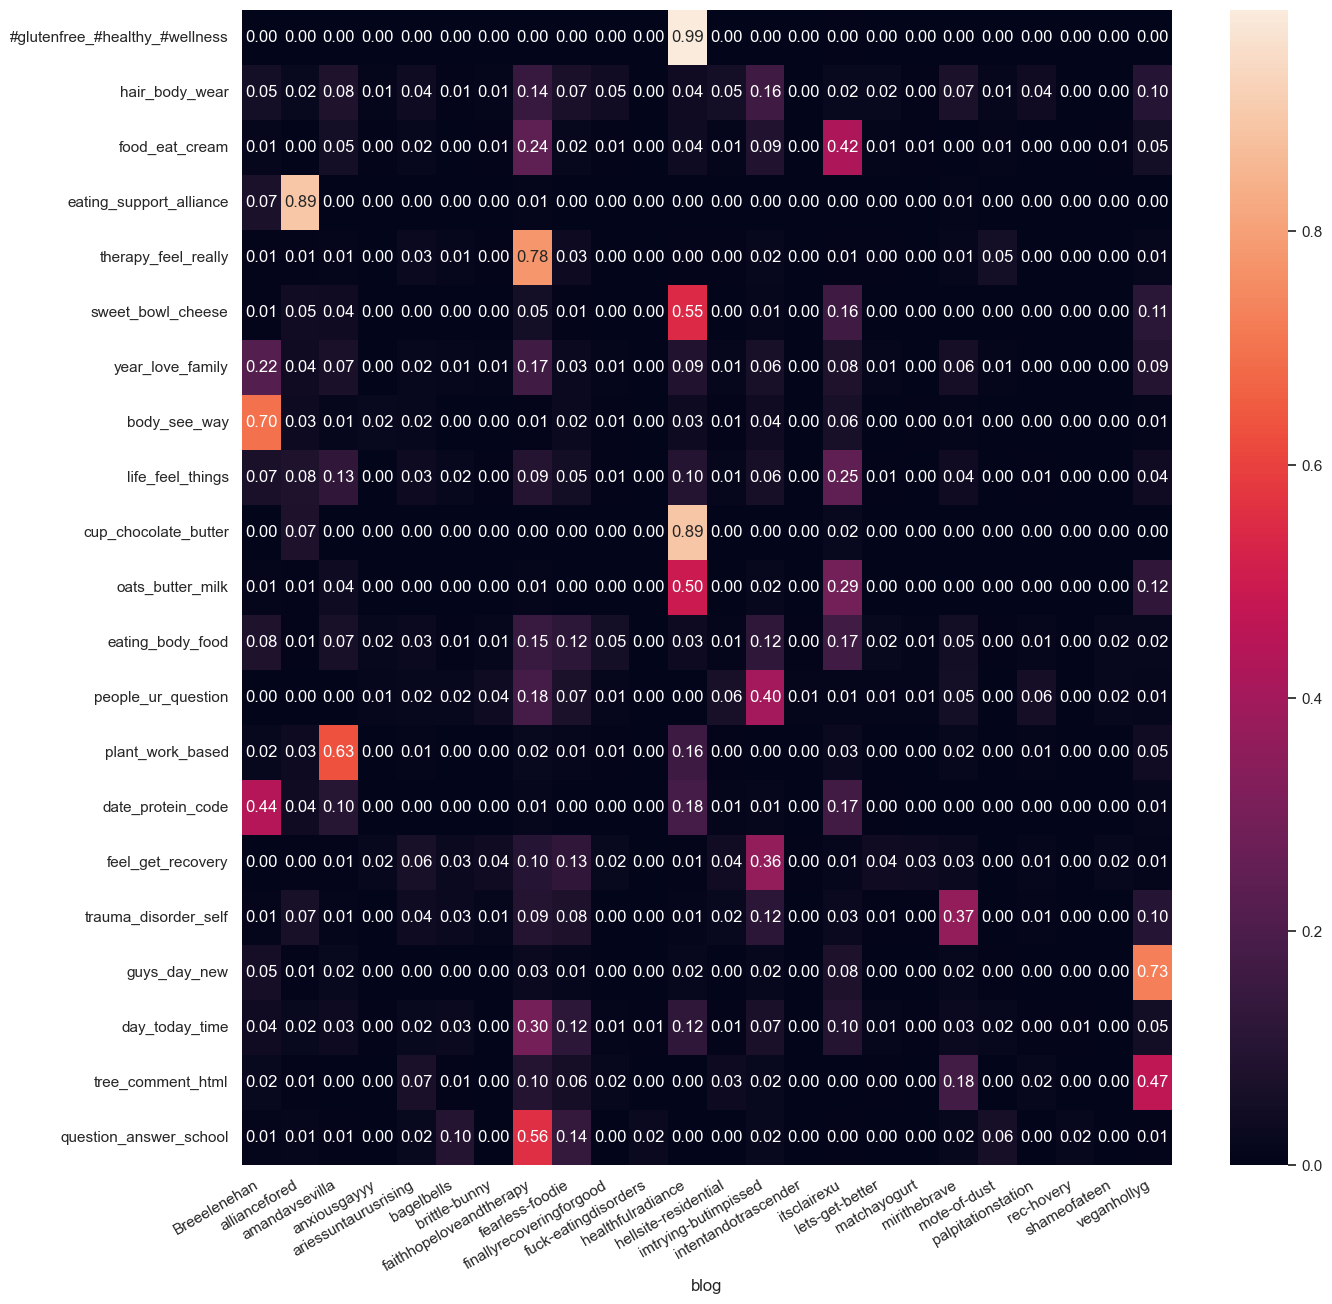

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(ddist_blog.iloc[:,0:-1].astype('float').T,fmt=".2f",annot=True)

plt.xticks(rotation=30,ha='right') 
plt.savefig('./result/edml/new_old_ed_13topics.svg')
# plt.show()

In [33]:
text_df[text_df.id.isin([10491,10596])]

id                                               text  \
6470   10491  kind sandwich ice cream sandwich cathyscle coo...   
6567   10596  shoutout pizza_mikeys creative unique pizzas c...   
12785  10596       thelovelynope deal food report hr harassment   

                                           original_text  \
6470   My kind of sandwich 😎 // ice cream sandwich fr...   
6567   Shoutout to @pizza_mikeys for having the most ...   
12785  thelovelynope:  I-I just don't know how to dea...   

                          date  \
6470       2018-08-28 18:34:30   
6567       2018-06-26 17:12:13   
12785  2020-07-12 12:02:11 GMT   

                                                     url  \
6470            https://www.instagram.com/p/BnCGVyeALTW/   
6567            https://www.instagram.com/p/Bkfu2BKA_OH/   
12785  https://hellsite-residential.tumblr.com/post/6...   

                       blog  Topic0_dist  Topic1_dist  Topic2_dist  \
6470            itsclairexu     0.001684     0.003492     0.898432   
6567            itsclairexu     0.001952     0.004048     0.882260   
12785  hellsite-residential     0.003244     0.006726     0.010792   

       Topic3_dist  ...  Topic11_select  Topic12_select  Topic13_select  \
6470      0.002312  ...             0.0             0.0             0.0   
6567      0.002680  ...             0.0             0.0             0.0   
12785     0.004452  ...             0.0             0.0             0.0   

       Topic14_select  Topic15_select  Topic16_select  Topic17_select  \
6470              0.0             0.0             0.0             0.0   
6567              0.0             0.0             0.0             0.0   
12785             0.0             0.0             0.0             0.0   

       Topic18_select  Topic19_select  Topic20_select  
6470              0.0             0.0             0.0  
6567              0.0             0.0             0.0  
12785             0.0             0.0             1.0  

[3 rows x 48 columns]

In [31]:
text_df[text_df.id.isin([4335,4872,4125,3120,2425])]


id                                               text  \
1102   2425  grew entire life allowed certain foods foods e...   
9403   2425  question feel helpful write fictional story su...   
9968   3120  time stop process journal tuesday therapy sess...   
10807  4125  therapy screenshot avoidant attachment gets ph...   
10987  4335  talking shhh terminating therapy coming end th...   
11408  4872  therapy rupture part sorry therapy session acc...   

                                           original_text  \
1102   I grew up my entire life thinking I'm allowed ...   
9403   Question: I feel like it would be helpful to w...   
9968   I haven't had time to stop and process (journa...   
10807  Therapy .. // screenshot  // avoidant attachme...   
10987  Talking about (shhh🤫) terminating therapy   As...   
11408  Therapy .. // rupture // part   I'm sorry this...   

                          date  \
1102       2022-08-24 10:39:12   
9403   2021-02-19 18:35:15 GMT   
9968   2020-09-10 20:02:30 GMT   
10807  2020-02-06 12:52:03 GMT   
10987  2020-01-08 19:18:49 GMT   
11408  2019-09-14 16:06:09 GMT   

                                                     url  \
1102            https://www.instagram.com/p/Cho522ChBNH/   
9403   https://faithhopeloveandtherapy.tumblr.com/pos...   
9968   https://faithhopeloveandtherapy.tumblr.com/pos...   
10807  https://faithhopeloveandtherapy.tumblr.com/pos...   
10987  https://faithhopeloveandtherapy.tumblr.com/pos...   
11408  https://faithhopeloveandtherapy.tumblr.com/pos...   

                          blog  Topic0_dist  Topic1_dist  Topic2_dist  \
1102              Breeelenehan     0.000914     0.000158     0.057580   
9403   faithhopeloveandtherapy     0.984433     0.000388     0.001292   
9968   faithhopeloveandtherapy     0.986348     0.000340     0.001133   
10807  faithhopeloveandtherapy     0.988824     0.000278     0.000927   
10987  faithhopeloveandtherapy     0.992517     0.000186     0.000621   
11408  faithhopeloveandtherapy     0.992363     0.000190     0.000634   

       Topic3_dist  ...  Topic4_select  Topic5_select  Topic6_select  \
1102      0.001345  ...            0.0            0.0            0.0   
9403      0.003309  ...            0.0            0.0            0.0   
9968      0.002902  ...            0.0            0.0            0.0   
10807     0.002375  ...            0.0            0.0            0.0   
10987     0.001590  ...            0.0            0.0            0.0   
11408     0.001623  ...            0.0            0.0            0.0   

       Topic7_select  Topic8_select  Topic9_select  Topic10_select  \
1102             0.0            1.0            0.0             0.0   
9403             0.0            0.0            0.0             0.0   
9968             0.0            0.0            0.0             0.0   
10807            0.0            0.0            0.0             0.0   
10987            0.0            0.0            0.0             0.0   
11408            0.0            0.0            0.0             0.0   

       Topic11_select  Topic12_select  Topic13_select  
1102              0.0             0.0             0.0  
9403              0.0             0.0             0.0  
9968              0.0             0.0             0.0  
10807             0.0             0.0             0.0  
10987             0.0             0.0             0.0  
11408             0.0             0.0             0.0  

[6 rows x 34 columns]

In [206]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

dataf_rnorm = robjects.DataFrame(ddist_blog.iloc[:,0:-1])
robjects.r(''' 
library(data.table)
topic.title.tall <- melt(setDT(ddist_blog), id.vars = c("title"), variable.name = "topic")
''')

KeyError: <class 'float'>

In [198]:
from plotnine import ggplot, aes, geom_line,geom_tile, scale_fill_gradient
(
ggplot(ddist_blog.iloc[:,0:-1], aes(x='blog')) +
    # geom_tile(aes(fill = value)) + 
    # geom_text(aes(label = round(value, 2))) +
    scale_fill_gradient(low = "white", high = "red")
    # +theme(text = element_text(size=20),axis.text.x = element_text(angle=45, hjust=1))
)

PlotnineError: "Could not evaluate the 'x' mapping: 'blog' (original error: name 'blog' is not defined)"

In [199]:
ddist_blog

eating_support_alliance_us bowl_oats_butter_almond  \
blog                                                                      
Breeelenehan                           0.004505                0.011943   
alliancefored                          0.901694                0.000727   
amandavsevilla                         0.009553                0.019371   
anxiousgayyy                           0.000502                     0.0   
healthfulradiance                      0.009095                0.587512   
imtrying-butimpissed                   0.024045                0.015182   
itsclairexu                            0.036686                0.293368   
veganhollyg                            0.013919                0.071898   

                     life_body_feel_like roasted_#healthy_oil_add  \
blog                                                                
Breeelenehan                    0.032642                 0.002196   
alliancefored                   0.074312                      0.0   
amandavsevilla                  0.158634                 0.015112   
anxiousgayyy                    0.020532                 0.000634   
healthfulradiance                0.09613                 0.699153   
imtrying-butimpissed            0.285263                 0.004865   
itsclairexu                      0.30226                  0.09059   
veganhollyg                     0.030227                 0.187451   

                     body_like_feel_day day_time_one_like  \
blog                                                        
Breeelenehan                   0.805447          0.123988   
alliancefored                  0.035109          0.021241   
amandavsevilla                 0.018207           0.11161   
anxiousgayyy                   0.002199          0.002959   
healthfulradiance              0.027373          0.112608   
imtrying-butimpissed           0.031289          0.040838   
itsclairexu                     0.05645          0.139927   
veganhollyg                    0.023927          0.446829   

                     cup_chocolate_butter_add        id  
blog                                                     
Breeelenehan                         0.006482   1873399  
alliancefored                        0.000715   6127291  
amandavsevilla                       0.005156   6136628  
anxiousgayyy                              0.0    132541  
healthfulradiance                    0.944535  14710522  
imtrying-butimpissed                      0.0   1490061  
itsclairexu                           0.03727  14539093  
veganhollyg                          0.005842  12825333